# AutoKeras implementation 

This notebook uses Autokeras, an automated machine learning library built upon Tensorflow and Keras. The goal of AutoKeras is to make machine learning accessible for everyone.

This example takes a real-life dataset [dogs vs cat](https://www.kaggle.com/c/dogs-vs-cats/data) and tries to train a well working image classifier without a user who decides which layers to use.

Please make sure that your driver configuration is correct (using Nvidia CUDA and cuDNN) and that the library makes its calculations on a GPU. Note that this code is written for AutoKeras v1.0.1 and may be updated for future versions.

Sources: Data Science with Python, Rohan Chopra and Aaron England; 

## Setup and data cleaning

In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report
from keras.datasets import cifar10
import autokeras as ak
import tensorflow.keras as keras
import os
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import accuracy_score
from random import shuffle

Using TensorFlow backend.


In [31]:
INPUT_PATH="data/train/"
OUTPUT_NAME="autokeras-model"
OUTPUT_CLASSES=2
SIZE=64
MAX_TRIES=50

In [3]:
def get_label(file):
    class_label = file.split('.')[0]
    if class_label == 'dog': label_vector = 0
    elif class_label == 'cat': label_vector = 1
    return label_vector

In [4]:
def get_data():
    data = []
    files = os.listdir(INPUT_PATH)
    for image in tqdm(files):
        
        label_vector = get_label(image)
        

        img = Image.open(INPUT_PATH + image).convert('L')
        img = img.resize((SIZE,SIZE))
        
        data.append([np.asarray(img),np.array(label_vector)])
        
    shuffle(data)
    return data

In [5]:
data = get_data()

100%|███████████████████████████████████████████████████████████████████████████| 25000/25000 [01:43<00:00, 240.89it/s]


In [6]:
train = data[:20000]
test = data[20000:]

print("Training dataset contains %d items" % len(train))
print("Testing dataset contains %d items" % len(test))

Training dataset contains 20000 items
Testing dataset contains 5000 items


In [34]:
x_train = np.array([data[0] for data in train], 'float32')
x_test = np.array([data[0] for data in test], 'float32')
y_train = [data[1] for data in train]
y_test = [data[1] for data in test]

In [35]:
#x_train = np.array(x_train).reshape(-1,SIZE,SIZE,1)
#x_test = np.array(x_test).reshape(-1,SIZE,SIZE,1)
x_train = x_train.reshape(x_train.shape[0], 50, 50)
x_test = x_test.reshape(x_test.shape[0], 50, 50)

#x_train /= 255
#x_test /= 255

y_train = np.array(y_train)
y_test = np.array(y_test)

#from tensorflow.keras.utils import to_categorical
#y_train = to_categorical(y_train)
#y_test = to_categorical(y_test)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(20000, 50, 50, 1)
(20000,)
(5000, 50, 50, 1)
(5000,)


## Training and model evaluation

In [ ]:
# Init image classifier.
clf = ak.ImageClassifier(max_trials=1, name=OUTPUT_NAME)
# Feed the image classifier with training data.
clf.fit(x_train,y_train, verbose=2)

In [37]:
predicted_y = clf.predict(x_test)

In [ ]:
print(clf.evaluate(x_test, y_test))

In [ ]:
model = clf.export_model()
model.save(OUTPUT_NAME + '/model.h5')
print('Model succesfully exported')
print(type(model))

In [25]:
from tensorflow.python.keras.models import load_model
from tensorflow.keras.layers.experimental.preprocessing import Normalization

cust = ak.CUSTOM_OBJECTS
cust['Normalization'] = Normalization

model = load_model(OUTPUT_NAME+'/model.h5', custom_objects=cust)

print("Model succesfully loaded")

Model succesfully loaded


In [26]:
predictions = model.predict(x_test)

In [ ]:
from sklearn.metrics import confusion_matrix
y_prediction = model.predict(x_test)
y_prediction = [int(round(p[0])) for p in y_prediction]
print('The confusion matrix is: ')
print(str(confusion_matrix(y_test, y_prediction)))

In [ ]:
instances = 0
correct_ones = 0

for i in range(0, len(predictions)):
    if i < 5:
        print("Prediction: ", predictions[i], ", Actual: ", y_test[i])
    if predictions[i] == y_test[i]:
        correct_ones += 1
    instances += 1
    
print(instances, correct_ones)

In [16]:
score = model.evaluate(x_test, y_test)

5000/5000 [==============================] - ETA: 45s - loss: 0.6944 - accuracy: 0.375 - ETA: 5s - loss: 0.6935 - accuracy: 0.465 - ETA: 3s - loss: 0.6934 - accuracy: 0.47 - ETA: 2s - loss: 0.6932 - accuracy: 0.49 - ETA: 1s - loss: 0.6933 - accuracy: 0.48 - ETA: 1s - loss: 0.6931 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.49 - ETA: 1s - loss: 0.6932 - accuracy: 0.49 - ETA: 0s - loss: 0.6932 - accuracy: 0.49 - ETA: 0s - loss: 0.6933 - accuracy: 0.48 - ETA: 0s - loss: 0.6933 - accuracy: 0.48 - ETA: 0s - loss: 0.6933 - accuracy: 0.48 - ETA: 0s - loss: 0.6932 - accuracy: 0.49 - ETA: 0s - loss: 0.6932 - accuracy: 0.49 - ETA: 0s - loss: 0.6932 - accuracy: 0.49 - ETA: 0s - loss: 0.6932 - accuracy: 0.49 - ETA: 0s - loss: 0.6932 - accuracy: 0.49 - ETA: 0s - loss: 0.6932 - accuracy: 0.49 - 1s 244us/sample - loss: 0.6932 - accuracy: 0.4962


In [17]:
print('Accuracy: {accuracy}'.format(accuracy=score))

Accuracy: [0.693196343421936, 0.4962]


In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns;sns.set()

plt.style.use('classic')
%matplotlib inline

mat = confusion_matrix(y_test, predictions)
labels = ['dog', 'cat']

sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, xticklabels=labels, yticklabels=labels)
plt.xlabel('true category')
plt.ylabel('predicted category')

## Keras model visualization

In [24]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 50, 50, 1)]       0         
_________________________________________________________________
normalization (Normalization (None, 50, 50, 1)         3         
_________________________________________________________________
conv2d (Conv2D)              (None, 46, 46, 32)        832       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 42, 42, 32)        25632     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 10, 10, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 10, 10, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 6, 6, 64)          51264 

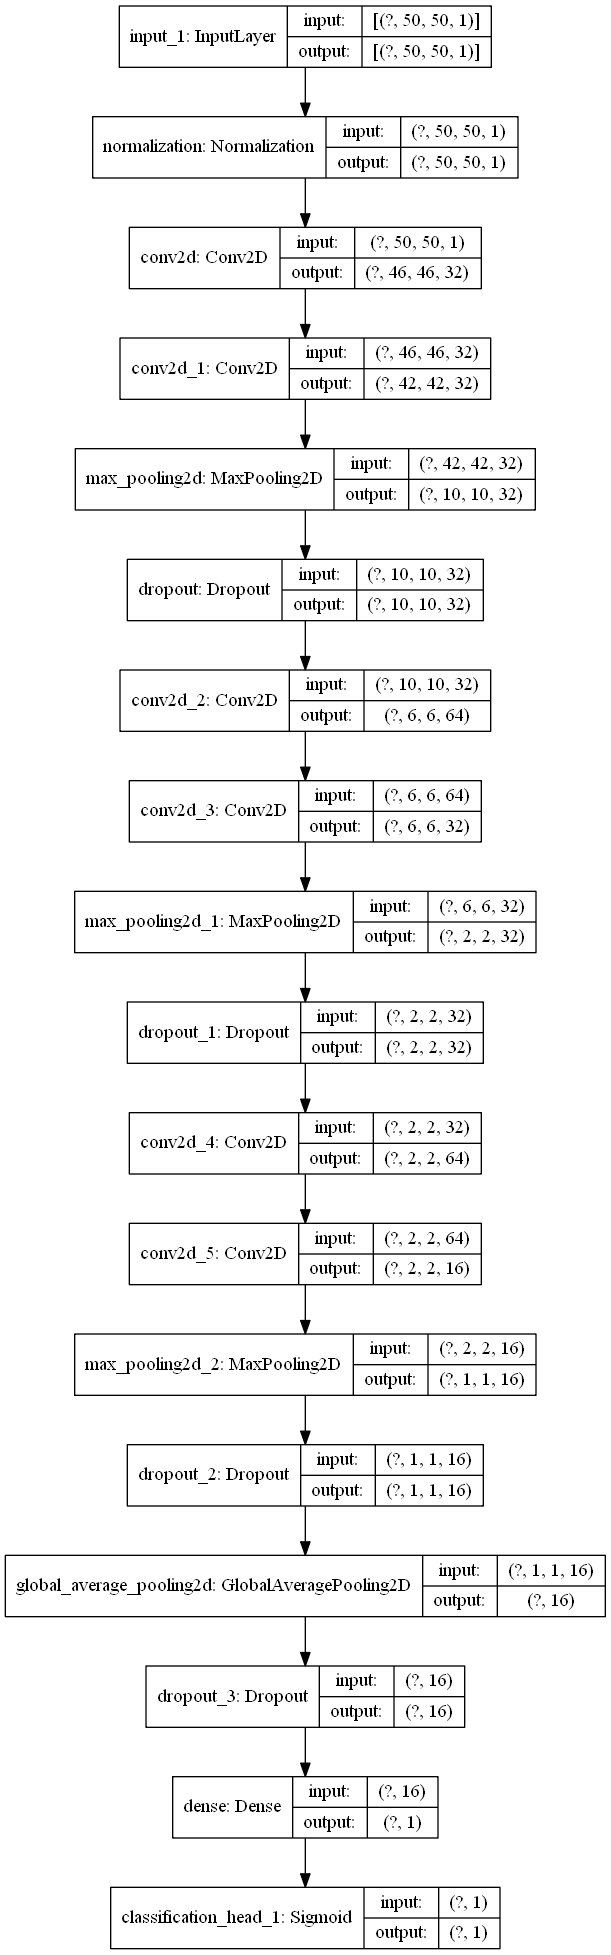

In [19]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file=OUTPUT_NAME + '/model.png', show_shapes=True, show_layer_names=True)